# **Dataset 3: Edge Hill University**

In this notebook we'll go through the entire process of exploratory data analysis, synthetic data generation (SDG) and evaluation for Dataset 3: Edge Hill University.

The evaluation approach that is used was suggested by  Liu et al. [1]. The goal is to provide a comprehensive evaluation for synthetic tabular data in learning analytics that encompasses utility, resemblance and privacy metrics. The dataset used in this notebook is from students studying computer science at a University in the UK and consists of 80 Instances [2].

Dataset source: https://data.mendeley.com/datasets/wf8568hxb7/1

**References:**

[1] Qinyi Liu, Mohammad Khalil, Ronas Shakya, and Jelena Jovanovic. 2024.
Scaling While Privacy Preserving: A Comprehensive Synthetic Tabular
Data Generation and Evaluation in Learning Analytics. In The 14th Learning
Analytics and Knowledge Conference (LAK ’24), March 18–22, 2024, Kyoto,
Japan. ACM, New York, NY, USA, 12 pages. https://doi.org/10.1145/3636555.
3636921

[2] Nnamoko, Nonso; Barrowclough, Joe (2022), “Student grade prediction dataset”, Mendeley Data, V1, doi: 10.17632/wf8568hxb7.1


### **Import Packages**

In [1]:
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import sys

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia
from sklearn.preprocessing import LabelEncoder

## **Exploratory Data Analysis**

In [2]:
# Load the dataset as dataframe
data_path = "../data/original_data/3_edge_hill_university/3_edge_hill_university.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,Gender,Age,POLAR4 Quintile,POLAR3 Quintile,Adult HE 2001 Quintile,Adult HE 2011 Quintile,TUNDRA MSOA Quintile,TUNDRA LSOA Quintile,Gaps GCSE Quintile,Gaps GCSE Ethnicity Quintile,...,distance to university (km),Count of Module Area Logins,Total Hours in Module Area,% of Average Hours in Module Area,# of presence,# of Absence,Percent Attended,"label (fail=1, pass=0)",Unnamed: 20,Unnamed: 21
0,0.0,38.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,...,13.333806,19.0,7.41,0.620767,3.0,9.0,25.000000,1.0,NaN,NaN
1,0.0,22.0,4.0,2.0,1.0,3.0,4.0,4.0,4.0,5.0,...,15.844126,1.0,0.03,0.002513,0.0,12.0,0.000000,1.0,NaN,NaN
2,0.0,21.0,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,...,17.706573,25.0,6.14,0.514374,5.0,7.0,41.666667,1.0,NaN,NaN
3,0.0,25.0,5.0,4.0,3.0,4.0,3.0,3.0,5.0,5.0,...,17.327498,3.0,0.16,0.013404,0.0,12.0,0.000000,1.0,NaN,NaN
4,0.0,20.0,5.0,4.0,3.0,4.0,3.0,3.0,4.0,4.0,...,0.000000,25.0,4.03,0.337610,11.0,1.0,91.666667,1.0,NaN,NaN


In [3]:
# Get general information about the dataset
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             80 non-null     float64
 1   Age                                80 non-null     float64
 2   POLAR4 Quintile                    80 non-null     float64
 3   POLAR3 Quintile                    80 non-null     float64
 4   Adult HE 2001 Quintile             80 non-null     float64
 5   Adult HE 2011 Quintile             80 non-null     float64
 6   TUNDRA MSOA Quintile               80 non-null     float64
 7   TUNDRA LSOA Quintile               80 non-null     float64
 8   Gaps GCSE Quintile                 80 non-null     float64
 9   Gaps GCSE Ethnicity Quintile       80 non-null     float64
 10  Uni Connect target ward            80 non-null     float64
 11  attending from home?               80 non-null     float64
 

In [4]:
# Check for missing values
original_data.isnull().sum()

Gender                                7
Age                                   7
POLAR4 Quintile                       7
POLAR3 Quintile                       7
Adult HE 2001 Quintile                7
Adult HE 2011 Quintile                7
TUNDRA MSOA Quintile                  7
TUNDRA LSOA Quintile                  7
Gaps GCSE Quintile                    7
Gaps GCSE Ethnicity Quintile          7
Uni Connect target ward               7
attending from home?                  7
distance to university (km)           7
Count of Module Area Logins           7
Total Hours in Module Area            7
% of Average Hours in Module Area     7
# of presence                         7
# of Absence                          9
Percent Attended                      7
label (fail=1, pass=0)                7
Unnamed: 20                          87
Unnamed: 21                          87
dtype: int64

In [5]:
original_data.tail(10)

,Gender,Age,POLAR4 Quintile,POLAR3 Quintile,Adult HE 2001 Quintile,Adult HE 2011 Quintile,TUNDRA MSOA Quintile,TUNDRA LSOA Quintile,Gaps GCSE Quintile,Gaps GCSE Ethnicity Quintile,...,distance to university (km),Count of Module Area Logins,Total Hours in Module Area,% of Average Hours in Module Area,# of presence,# of Absence,Percent Attended,"label (fail=1, pass=0)",Unnamed: 20,Unnamed: 21
77,0.0,22.0,3.0,4.0,3.0,4.0,3.0,3.0,5.0,5.0,...,10.235646,32.0,5.68,0.475838,11.0,1.0,91.666667,0.0,NaN,NaN
78,1.0,21.0,5.0,4.0,3.0,4.0,4.0,4.0,4.0,5.0,...,56.938766,35.0,15.59,1.306041,8.0,4.0,66.666667,0.0,NaN,NaN
79,1.0,20.0,5.0,5.0,4.0,4.0,3.0,3.0,5.0,5.0,...,20.031985,23.0,16.30,1.365520,5.0,7.0,41.666667,0.0,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Findings: 
- 2 columns without any values
- last 7 rows without any values
- 2 additional missing values in column '# of Absence'

Thus:
- remove empty rows and columns and fill remaining missing values

In [6]:
# Drop empty columns
original_data.drop(['Unnamed: 20'], axis=1, inplace=True)
original_data.drop(['Unnamed: 21'], axis=1, inplace=True)

# Drop last 7 rows
original_data.drop(original_data.tail(7).index, inplace=True)
original_data.tail(10)

# Fill missing values with the mode of the column
original_data = original_data.fillna(original_data.mode().iloc[0])


In [7]:
# Check again for missing values
original_data.isnull().sum()

Gender                               0
Age                                  0
POLAR4 Quintile                      0
POLAR3 Quintile                      0
Adult HE 2001 Quintile               0
Adult HE 2011 Quintile               0
TUNDRA MSOA Quintile                 0
TUNDRA LSOA Quintile                 0
Gaps GCSE Quintile                   0
Gaps GCSE Ethnicity Quintile         0
Uni Connect target ward              0
attending from home?                 0
distance to university (km)          0
Count of Module Area Logins          0
Total Hours in Module Area           0
% of Average Hours in Module Area    0
# of presence                        0
# of Absence                         0
Percent Attended                     0
label (fail=1, pass=0)               0
dtype: int64

In [8]:
# Check number of unique values in each column
original_data.nunique()

Gender                                2
Age                                  12
POLAR4 Quintile                       5
POLAR3 Quintile                       5
Adult HE 2001 Quintile                5
Adult HE 2011 Quintile                6
TUNDRA MSOA Quintile                  6
TUNDRA LSOA Quintile                  6
Gaps GCSE Quintile                    6
Gaps GCSE Ethnicity Quintile          6
Uni Connect target ward               2
attending from home?                  2
distance to university (km)          46
Count of Module Area Logins          49
Total Hours in Module Area           78
% of Average Hours in Module Area    78
# of presence                        12
# of Absence                         11
Percent Attended                     14
label (fail=1, pass=0)                2
dtype: int64

<Axes: xlabel='label (fail=1, pass=0)', ylabel='Count'>

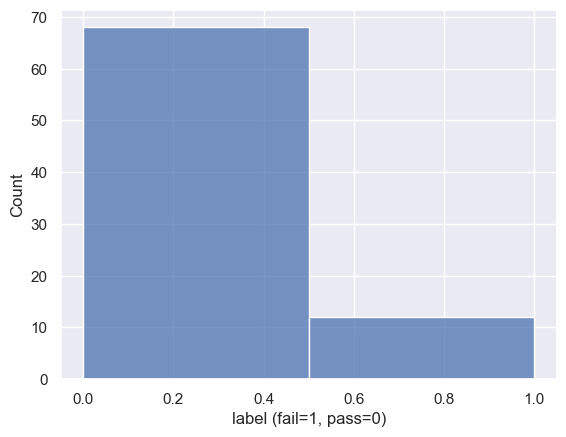

In [9]:
sns.histplot(original_data["label (fail=1, pass=0)"], bins=2)

In [10]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

## **Synthetic Data Generation**

Now we'll prepare for SDG and split up the original data into 30/70 test/train splits. If the splits were created earlier already, we will load the existing splits.

In [11]:
original_data_path = "../data/original_data/3_edge_hill_university/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    # Split the data into train and test sets (70% train, 30% test) according to evaluation paper
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data loaded.


First check whether the synthetic datasets were already generated. If not, use the train split to train the SDG models and sample as many entries as the train dataset contains. 

In [12]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

synth_path = "../data/synthetic_data/3_edge_hill_university/"
dataset_name = "3_edge_hill_university"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]

# Number of samples to generate
n = len(train_data)

if len(csv_files) == 0:

    # Use train_data.csv to fit SDG models and generate synthetic data
    data_path = original_data_path + "train_data.csv"
    arguments = [data_path, str(n), dataset_name]

    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("Sampling DataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)
else:
    print("Synthetic data already exists.")

Synthetic data already exists.


Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [13]:
# Load the synthetic data as dataframe
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])
    original_data[col] = le.fit_transform(original_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le

In [14]:
train_data["label (fail=1, pass=0)"].value_counts()

label (fail=1, pass=0)
0.0    49
1.0     7
Name: count, dtype: int64

In [15]:
tvae["label (fail=1, pass=0)"].value_counts()

label (fail=1, pass=0)
0.0    56
Name: count, dtype: int64

## **Evaluation**

In [16]:
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]

### **Resemblance**

The resemblance dimension includes mutliple distance metrics to measure the similarity of the synthetic and real data: **Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance**

- **Difference in pairwise correlation** is used to measure how well feature-interactions are preserved within synthetic data. First the pairwise correlation matrices for each real and synthetic data is computed. Pearson correlation coefficient is used for continuous features ( [-1,1] range) and the Theil uncer-
tainty coefficient ([0,1] range) for categorical features
    - lower (difference) values are better
- **JSD** is a method for measuring similarity between two probability distributions. It is based on Kullback-Leibler divergence, but has several benefits like being symmetric and having finite values. Values are bounded between 0 and 1, where values close to 0 indicate high similarity and values close to 1 indicate almost no similarity between the distributions.
    - lower values are better
- **WD** is used to compare the distributions of two continuous/mixed variables, where one variable is derived from the other → how well the synthetic data emulates the distribution of the
individual variables
    - lower values are better


**Difference in pairwise correlation:**

In [17]:
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")
rows = []

if (corr_diff_df["Dataset"] == 3).any():
    print("Entry for '3_edge_hill_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_dataset)
        rows.append([3,model_names[i], result])

    rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
    corr_diff_df = pd.concat([corr_diff_df, rows])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)
    
corr_diff_df.tail(6)

Entry for '3_edge_hill_university' already exists


,Dataset,Model,Pairwise Corr Diff
24,5,synthpop,0.068662
25,5,ds,0.135631
26,5,tvae,0.112384
27,5,gaussian_copula,0.088445
28,5,copula_gan,0.098838
29,5,ctgan,0.099111


**Jensen-Shannon Divergence**

In [18]:
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")
rows = []

if (jsd_df["Dataset"] == 3).any():
    print("Entry for '3_edge_hill_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = jsd(train_data, synth_dataset)
        rows.append([3,model_names[i], result])

    rows = pd.DataFrame(rows, columns=jsd_df.columns)
    jsd_df = pd.concat([jsd_df, rows])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)
    
jsd_df.tail(6)

Entry for '3_edge_hill_university' already exists


,Dataset,Model,JSD Diff
24,5,synthpop,0.002518
25,5,ds,0.094244
26,5,tvae,0.173274
27,5,gaussian_copula,0.009733
28,5,copula_gan,0.024876
29,5,ctgan,0.026296


**Wasserstein Distance**

In [19]:
wd_df = pd.read_csv("../data/results/tables/wd.csv")
rows = []

if (wd_df["Dataset"] == 3).any():
    print("Entry for '3_edge_hill_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = wd(train_data, synth_dataset)
        rows.append([3,model_names[i], result])

    rows = pd.DataFrame(rows, columns=wd_df.columns)
    wd_df = pd.concat([wd_df, rows])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)

wd_df.tail(6)

Entry for '3_edge_hill_university' already exists


,Dataset,Model,WD Diff
24,5,synthpop,0.021479
25,5,ds,0.124192
26,5,tvae,0.274399
27,5,gaussian_copula,0.015656
28,5,copula_gan,0.040430
29,5,ctgan,0.035582


In [20]:
from evaluation.sd_metrics import sd_metrics


for i, synth_dataset in enumerate(synth_datasets):
    print(f"Calculating metrics for {model_names[i]}...")
    print(sd_metrics(train_data, synth_dataset), "\n")

Calculating metrics for synthpop...


Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.905357            0.134158 

Calculating metrics for ds...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.609821            0.456811 

Calculating metrics for tvae...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.790179            0.524162 

Calculating metrics for gaussian_copula...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0        0.85625            0.668509 

Calculating metrics for copula_gan...
Property  Data Validity  Data Structure  Column Shapes  Column Pair Trends
Score               1.0             1.0       0.816071            0.637788 

Calculating metrics for ctgan...
Property  Data Validity  Data Structure  Column Shapes  Column P

### **Privacy**

To assess the privacy aspect of the synthetic data the metrics **Distance to closest Record (DCR)**, **Nearest Neighbour Difference Ratio (NNDR)** and **Membership Inference Attack (MIA)** will be used. 

- In **DCR** the euclidean distance between
each record in original and synthetic dataset is computed. DCR is the minimum distance between a synthetic record and a original record. 
    - A value of zero indicates that the synthetic record is an identical copy of the original one -> leak of real information, higher values indicate more privacy

- **NNDR** is ratio between nearest and second nearest real neighbour to any corresponding synthetic record (NNDR(s) = d1/d2) and is within [0,1]
    - higher values indicate better privacy

- **MIA** is used to assess the disclosure risk by assuming that an attacker has access to all the records of the synthetic data and to a random subset of the original data. Using a real record the attacker then tries to find the closest record in the synthetic dataset. If there is any distance below some threshold, the attacker can assume that the corresponding real record was used to generate the synthetic data.
    - For strong privacy preservation both accuracy and precision should be below 0.5 for all thresholds

**Distance to closest record (DCR)**

In [21]:
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")
rows = []

if (dcr_df["Dataset"] == 3).any():
    print("Entry for '3_edge_hill_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_hist=True)
        result_within_real = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Original", save_hist=True)
        result_within_synth = dcr(train_data, synth_dataset, model_names[i], dataset_name=dataset_name, within="Synthetic", save_hist=True)
        rows.append([3,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=dcr_df.columns)
    dcr_df = pd.concat([dcr_df, rows])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)
    
dcr_df.tail(6)
        

Entry for '3_edge_hill_university' already exists


,Dataset,Model,DCR 5th Percentile,DCR 5th Percentile (within Real),DCR 5th Percentile (within Synthetic)
24,5,synthpop,3.708,3.708,3.742
25,5,ds,6.671,3.708,4.975
26,5,tvae,4.243,3.708,2.000
27,5,gaussian_copula,4.243,3.708,4.243
28,5,copula_gan,4.796,3.708,4.123
29,5,ctgan,5.454,3.708,4.873


**Nearest Neighbor distance ratio (NNDR)**

In [22]:
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")
rows = []

if (nndr_df["Dataset"] == 3).any():
    print("Entry for '3_edge_hill_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        result = nndr(train_data, synth_dataset)
        result_within_real = nndr(train_data, synth_dataset, within="Original")
        result_within_synth = nndr(train_data, synth_dataset, within="Synthetic")
        rows.append([3,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=nndr_df.columns)
    nndr_df = pd.concat([nndr_df, rows])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)

nndr_df.tail(6) 

Entry for '3_edge_hill_university' already exists


,Dataset,Model,NNDR 5th percentile,NNDR 5th percentile (within Real),NNDR 5th percentile (within Synthetic)
24,5,synthpop,0.750,0.771,0.791
25,5,ds,0.403,0.771,0.663
26,5,tvae,0.858,0.771,0.000
27,5,gaussian_copula,0.799,0.771,0.794
28,5,copula_gan,0.837,0.771,0.832
29,5,ctgan,0.500,0.771,0.775


**Membership Inference Attack (MIA)**

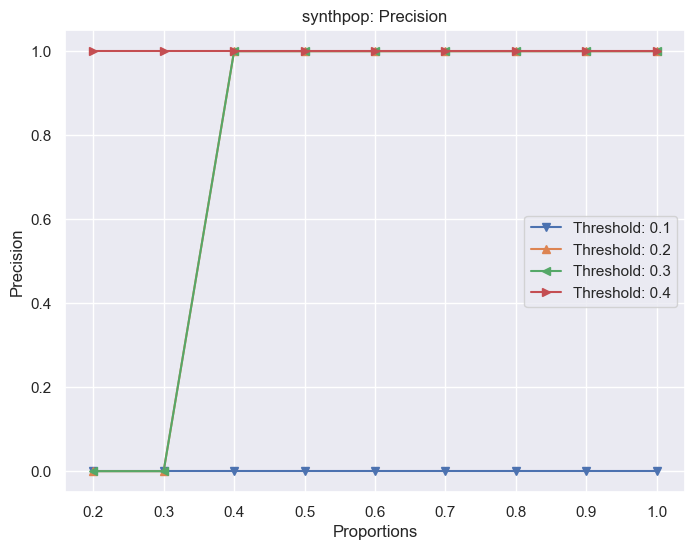

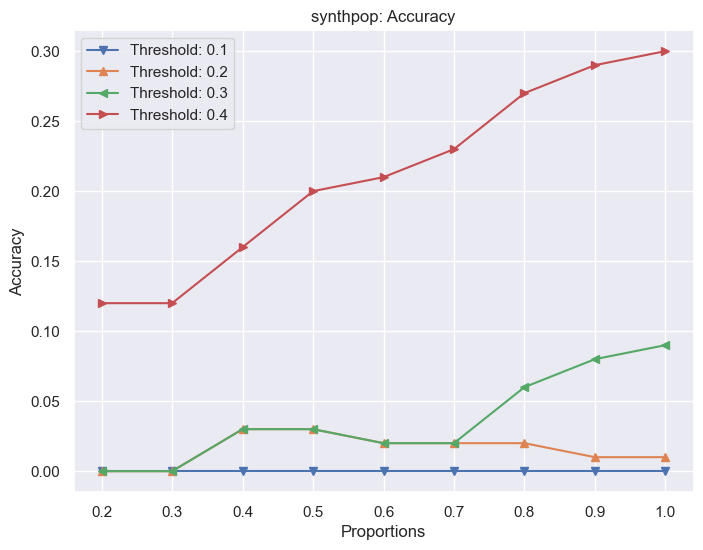

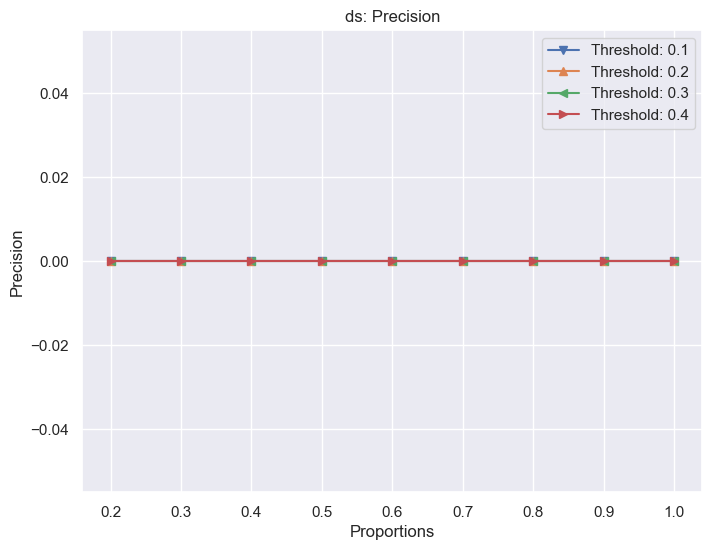

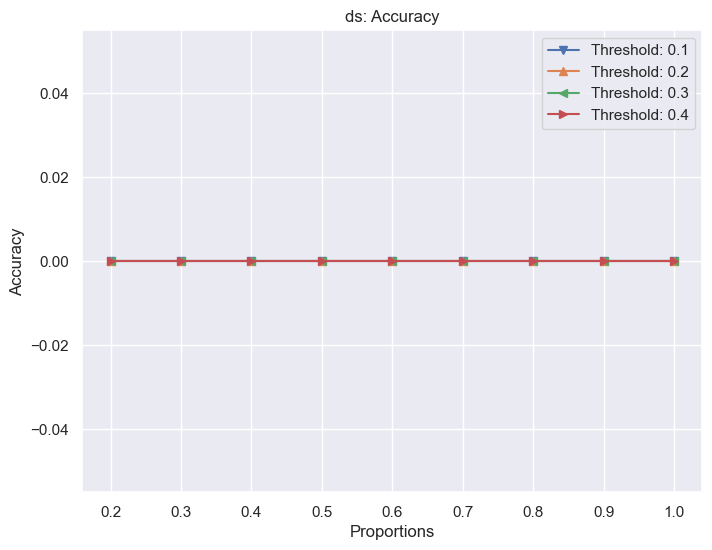

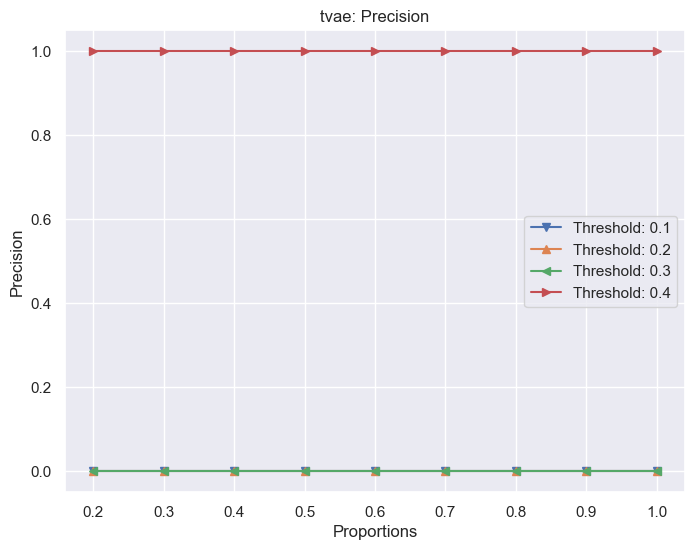

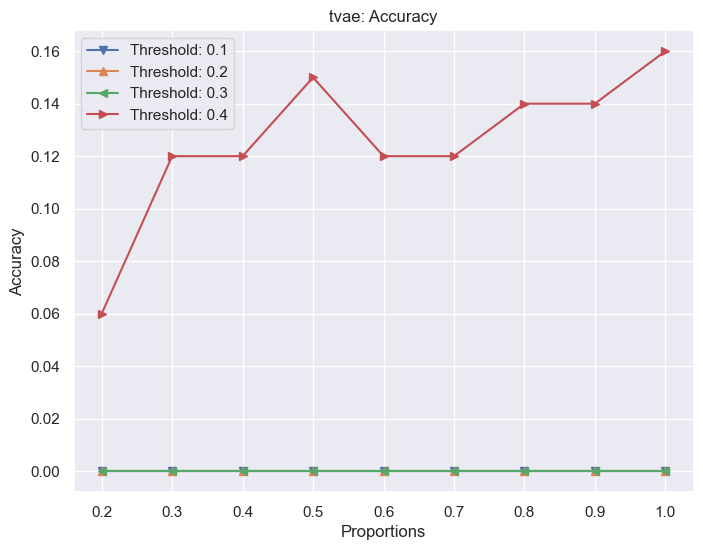

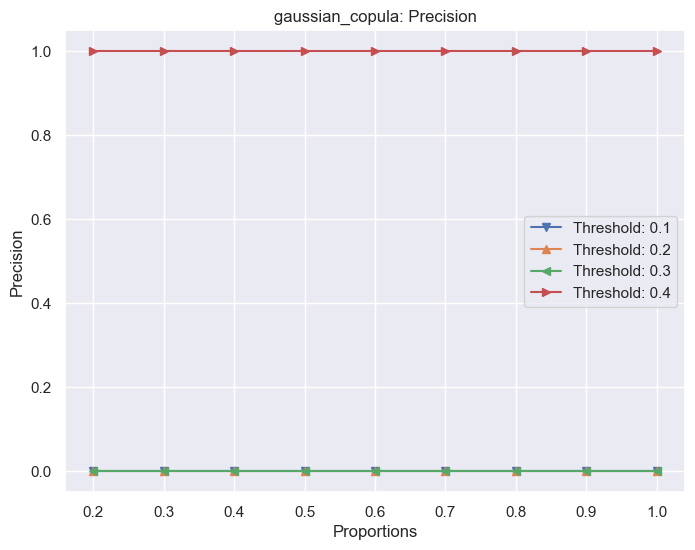

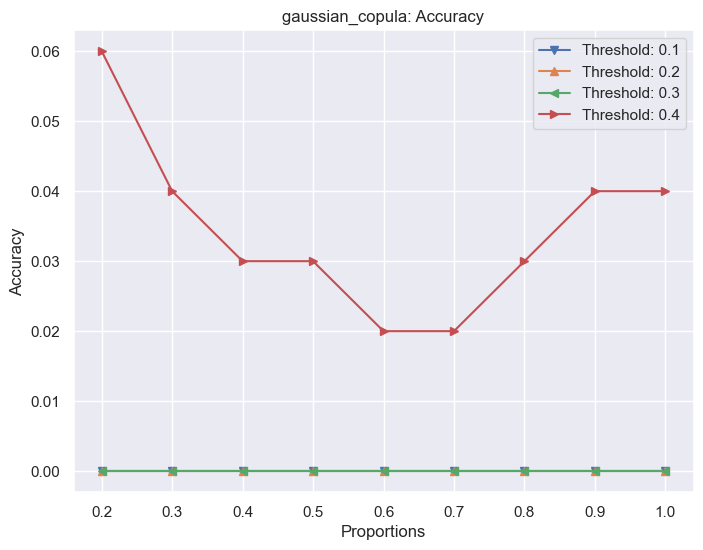

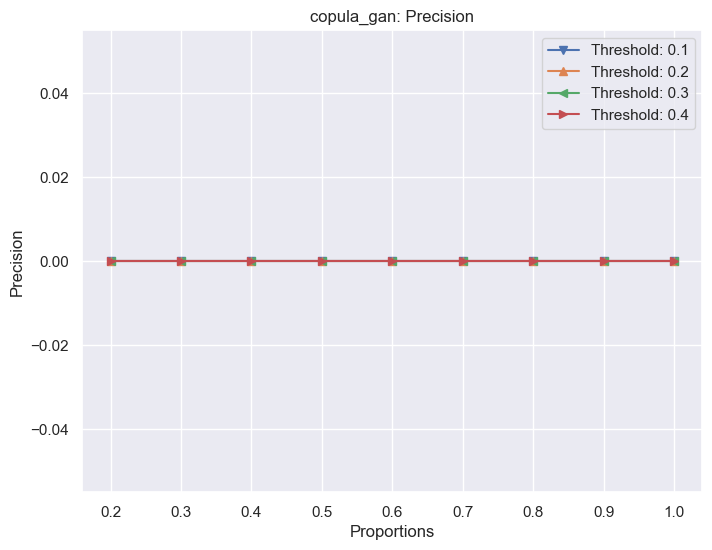

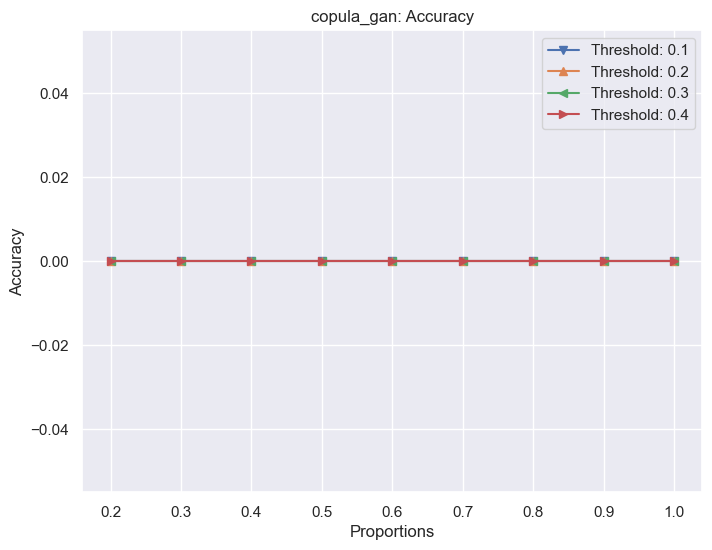

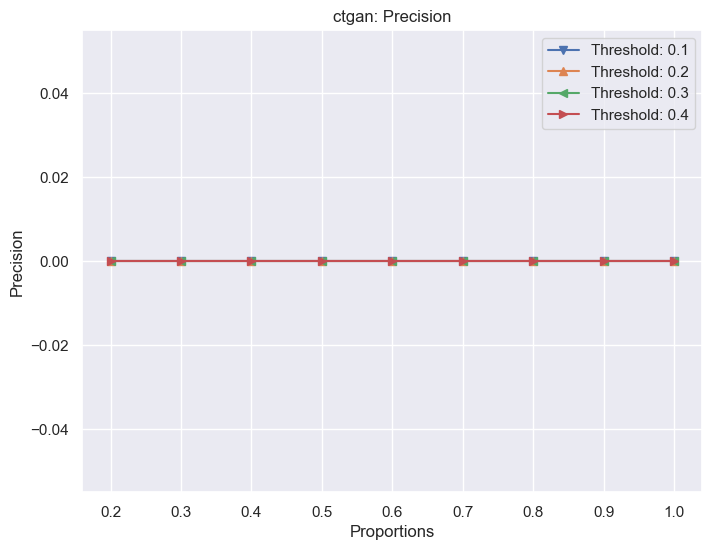

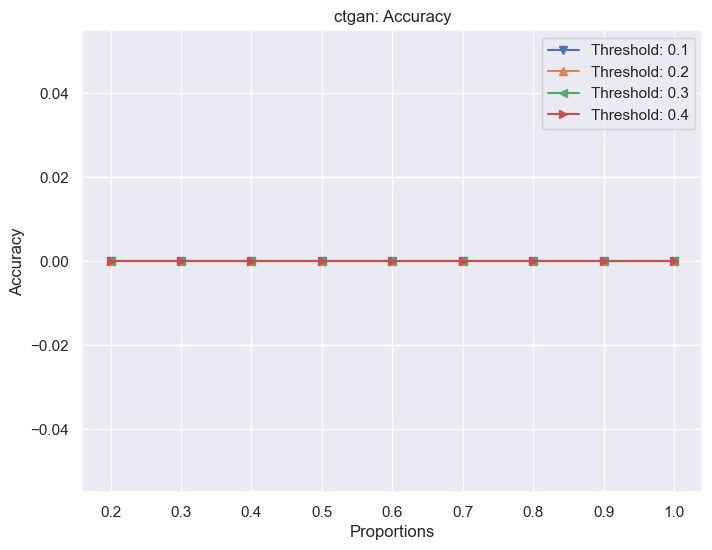

In [23]:
import glob

mia_results = {}
mia_path = "../data/results/plots/mia/3_edge_hill_university/"
mia_files = glob.glob(os.path.join(mia_path, "*.png"))
if (mia_files):
    print("MIA results already exist.")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(original_data, train_data, synth_dataset, model_names[i], dataset_name=dataset_name, save_plts=True)


In [24]:
proportions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

rows = []
for model, metrics in mia_results.items():
    for metric, thresholds in metrics.items():
        for threshold, values in thresholds.items():
            for proportion, value in zip(proportions, values):
                rows.append([3,model, metric, threshold, proportion, value])
                
mia_df = pd.read_csv("../data/results/tables/mia.csv")
rows = pd.DataFrame(rows, columns=mia_df.columns)
mia_df = pd.concat([mia_df, rows])
mia_df.to_csv("../data/results/tables/mia.csv", index=False)
mia_df.head()

,Dataset,Model,Metric,Threshold,Proportion,Value
0,1,synthpop,precision,0.1,0.2,0.0
1,1,synthpop,precision,0.1,0.3,0.0
2,1,synthpop,precision,0.1,0.4,0.0
3,1,synthpop,precision,0.1,0.5,0.0
4,1,synthpop,precision,0.1,0.6,0.0


### **Utility**

In order to evaluate the utility of the synthetic datasets, the following steps will executed three times, each time with a different ML model.

1. Two models are trained: one using the original train data and the other one using synthetic data.
2. The two different models will predict the target column using the test split.
3. The difference in performance between the two models will be reported via accuracy diff, f1-score diff, and auc-roc diff

In [73]:
# Set target column for utility evaluation
target_col = "label (fail=1, pass=0)"

Run random forest classifier for utility evaluation

In [74]:
rf_results = {}
rf_df = pd.read_csv("../data/results/tables/rf.csv")
rows = []

if (rf_df["Dataset"] == 3).any():
    print("Entry for '3_edge_hill_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "random_forest")
        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]
        rows.append([3, model_names[i], acc_diff, f1_diff, roc_auc_diff])
        
    rows = pd.DataFrame(rows, columns=rf_df.columns)
    rf_df = pd.concat([rf_df, rows], ignore_index=True)
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)

rf_df.tail(6)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
12,3,synthpop,0.00,-0.03,-0.13
13,3,ds,0.08,0.09,0.29
14,3,tvae,0.00,0.05,0.18
15,3,gaussian_copula,0.00,0.05,0.14
16,3,copula_gan,0.00,0.05,0.24
17,3,ctgan,0.00,0.05,0.16


Run logistic regression for utility evaluation

In [75]:
lr_results = {}
lr_df = pd.read_csv("../data/results/tables/lr.csv")
rows = []

if (lr_df["Dataset"] == 3).any():
    print("Entry for '3_edge_hill_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        try:
            lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "logistic_regression")

            acc_diff = lr_results[model_names[i]]["acc_diff"]
            f1_diff = lr_results[model_names[i]]["f1_diff"]
            roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

            rows.append([3, model_names[i], acc_diff, f1_diff, roc_auc_diff])
        except Exception as e:
            print(f"An error occurred with model {model_names[i]}: {e}")
            continue    
    rows = pd.DataFrame(rows, columns=lr_df.columns)
    lr_df = pd.concat([lr_df, rows])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)

lr_df.tail(6)

An error occurred with model tvae: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
11,2,ctgan,0.13,0.22,0.11
0,3,synthpop,0.04,0.01,0.01
1,3,ds,0.09,0.09,0.16
2,3,gaussian_copula,-0.17,-0.15,0.03
3,3,copula_gan,-0.04,-0.02,0.11
4,3,ctgan,-0.04,-0.02,0.15


Run multilayer perceptron (MLP)

In [76]:
mlp_results = {}
mlp_df = pd.read_csv("../data/results/tables/mlp.csv")
rows = []

if (mlp_df["Dataset"] == 3).any():
    print("Entry for '3_edge_hill_university' already exists")
else:
    for i, synth_dataset in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_dataset, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([3, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=mlp_df.columns)
    mlp_df = pd.concat([mlp_df, rows])
    mlp_df.to_csv("../data/results/tables/mlp.csv", index=False)
    
mlp_df.tail(6)

,Dataset,Model,Accuracy Difference,F1 Score Difference,ROC AUC Difference
0,3,synthpop,0.00,0.00,-0.03
1,3,ds,0.21,0.12,-0.08
2,3,tvae,0.00,0.00,0.00
3,3,gaussian_copula,0.00,0.00,0.01
4,3,copula_gan,0.00,0.00,0.01
5,3,ctgan,0.04,0.02,-0.02
